# クラスタリング(3) -- 時系列クラスタリングの実践

今回は実際にデータに対して時系列クラスタリングの計算を行っていく。

In [11]:
# 利用するモジュールのインポート
from collections import Counter
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as hierarchy
from scipy.spatial.distance import euclidean, squareform

In [2]:
# 分析・可視化のための関数を定義する。

def calc_seq_distance_matrix(x, width, f_metric, step=1):
    """系列から区間同士の距離行列を計算する。
    
    具体的には、指定された引数に従って系列全体を複数の「窓」に分割し、
    総当たりで距離を求めた結果を計算した正方行列を計算する。
    
    Parameters
    ----------------
    
    x: 計算対象の系列
    width: 窓の幅
    f_metric: 距離計算用の関数
    step: 窓をずらす長さ
    
    """
    # 生成される窓の数を計算する。
    n_seqs = (len(x) - width) // step + 1
    # 返り値を格納する np.array を作成する。
    value = np.zeros((n_seqs, n_seqs), np.float)
    
    for i in range(n_seqs):
        for j in range(n_seqs):
            value[i, j] = f_metric(
                x[i * step: i * step + width],
                x[j * step: j * step + width]
            )
    return value


def plot_serie_cluster(x, clusters, width, size=(7, 2), window_ticks=None, step=1):
    """系列のクラスターをプロットする。
    
    Parameters
    ----------------
    
    x: 系列データ
    clusters: クラスターの番号の列(クラスター番号は0始まりの連続する整数値であること)
    width: 窓の幅
    step: 窓関数を動かす際の大きさ
    
    """
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    fig, axs = plt.subplots(n_clusters, figsize=(size[0], size[1] * n_clusters))
    # 平均値を計算するために合計値を貯める配列を生成する
    sums_x_cl = {i: np.zeros(width) for i in range(n_clusters)}
    n_data_points = Counter(clusters)
    if window_ticks is None:
        window_ticks = np.arange(width)

    for i, cl in enumerate(clusters):
        x_i = x[i * step: i * step + width]
        axs[cl].plot(window_ticks, x_i, color="gray")
        sums_x_cl[cl] += x_i

    for cl in unique_clusters:
        # 各クラスタの平均値の系列をプロット
        mean_x_cl = sums_x_cl[cl] / n_data_points[cl]
        axs[cl].plot(window_ticks, mean_x_cl, color="black", linewidth=1.5)
        # サブプロットのタイトルを表示
        axs[cl].set_title(f"Cluster{cl} (size={n_data_points[cl]})")
        axs[cl].label_outer()
    
    return fig, axs

In [12]:
# データを読み込む
df_raw = pd.read_csv("../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv", 
                     names=['vin', 'time1', 'time2', 'feature', 'value'])

In [13]:
df_raw.head()

,vin,time1,time2,feature,value
0,21,201604200627,0.295909,0FA53,0.0
1,21,201604200627,0.295909,0FA57,4.0
2,21,201604200627,0.295909,0FA43,0.0
3,21,201604200627,0.295909,0FA44,0.0
4,21,201604200627,0.295909,0FA45,0.0


In [14]:
# 前処理として、0.1 秒単位でビンを切って中央値で集約し、欠損値については線形補間を行う
df = (
    df_raw
    .assign(rounded_time2=np.round(df_raw.time2, 1)) # time2を小数点以下1桁(0.1)で丸めて rounded_time2 列とする
    .groupby(["vin", "time1","rounded_time2","feature"])["value"].median() # 中央値で集約
    .unstack(level=-1) # feature列について横積みにする
    .interpolate() # NA を線形補完する
    .dropna() # 残った NA （先頭にNAがあったケース）を除外する
)

In [15]:
# 速度 (vehicle speed) の列を利用する。
vehicle_speed = df['31417']

In [22]:
%%time 
# ユークリッド距離により距離行列を計算する。窓の幅は10秒で、5秒ずつずらす。
speed_dist_mtx = calc_seq_distance_matrix(vehicle_speed, width=100, step=50,
                                                f_metric=euclidean)

CPU times: user 6.14 s, sys: 33.5 ms, total: 6.17 s
Wall time: 6.2 s


In [24]:
speed_dist_mtx.shape

(118, 118)

In [23]:
speed_dist_mtx

array([[  0.        ,   0.        ,   0.        , ..., 362.75849232,
        274.75617798, 130.55756943],
       [  0.        ,   0.        ,   0.        , ..., 362.75849232,
        274.75617798, 130.55756943],
       [  0.        ,   0.        ,   0.        , ..., 362.75849232,
        274.75617798, 130.55756943],
       ...,
       [362.75849232, 362.75849232, 362.75849232, ...,   0.        ,
        127.85410644, 280.3894491 ],
       [274.75617798, 274.75617798, 274.75617798, ..., 127.85410644,
          0.        , 168.23874796],
       [130.55756943, 130.55756943, 130.55756943, ..., 280.3894491 ,
        168.23874796,   0.        ]])

In [26]:
# scipy の linkage 関数を利用して距離行列に階層型クラスタリングを適用する。
connection = hierarchy.linkage(squareform(speed_dist_mtx), method='average')

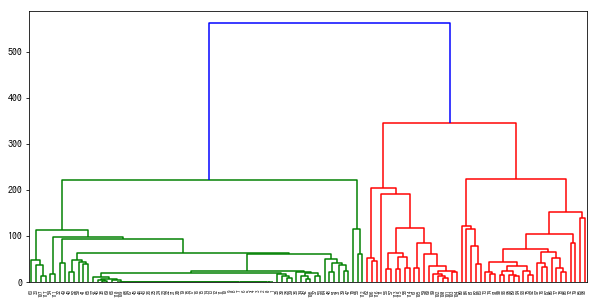

In [28]:
# 上のクラスタリング結果の樹状図を作成する。
plt.figure(figsize=(10, 5))
dend = hierarchy.dendrogram(connection)

 上の樹状図を見ると大きく距離の離れた二つの比較的サイズの似たクラスタがあることがわかる。
 
 これがどのようなまとまり方をしているのかを確認してみよう。

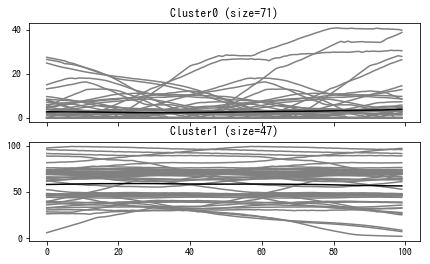

In [29]:
# クラスタ数2つでの時系列のプロット
plot_serie_cluster(vehicle_speed.values, 
                   hierarchy.fcluster(connection, 2, criterion='maxclust') - 1, width=100, step=50); plt.show()

Cluster0は0付近で推移する系列が多く、それに対してCluster1は平均50以上とある程度の速度が出ている系列が多いことが見て取れる。
窓の中の系列の形状パターン(＝この場合は加減速のパターン)というよりは全体的な速度でクラスタが分かれていることがわかる。

ここではさらにこの速度ベースのクラスタリングを見て行くが、もし加減速のパターンにより着目するのであれば

  - 窓の中での相対的な値を見る
  - 前後での差分を取る
  
といった方法が考えられるだろう。

次に、クラスタ数をもう少し増やして6にしてみよう。

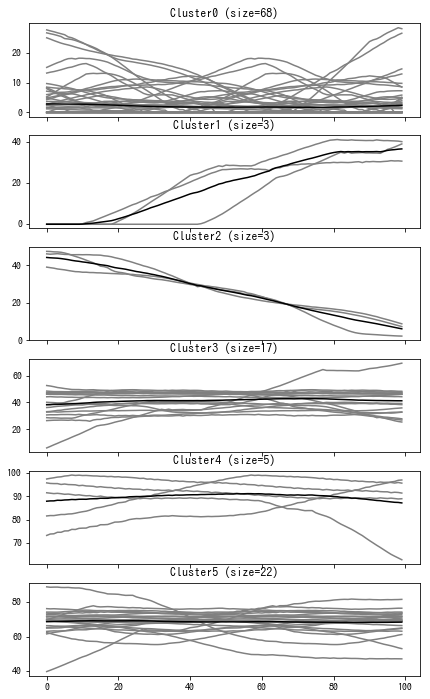

In [30]:
plot_serie_cluster(vehicle_speed.values, hierarchy.fcluster(connection, 6, criterion='maxclust') - 1, width=100, step=50); plt.show()

クラスタ1,2のように加減速という系列的な特徴を捉えたクラスタが現れてきた。一方でクラスタ0には加減速のパターンが入り乱れていることがわかる。よりクラスタ数を増やしてみよう。

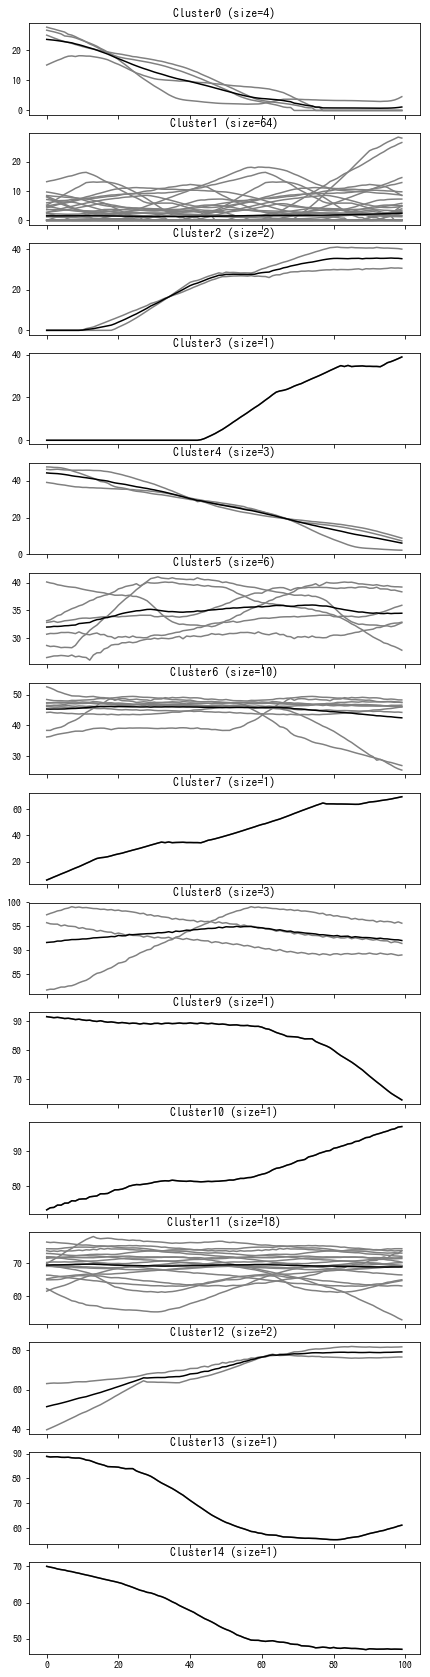

In [31]:
plot_serie_cluster(vehicle_speed.values,  hierarchy.fcluster(connection, 15, criterion='maxclust') - 1, width=100, step=50); plt.show()

クラスタ数6で計算した場合のクラスタ0の大部分はクラスタ0と1に移行しており、減速パターンの多く（ただし全てではない）が分離されているといえよう。しかし一方でクラスタ2と3を見ると同じように0から加速して行くパターンであるが別のクラスタになってしまっている。クラスタ1にも一見するとクラスタ2や3に含まれても良さそうな加速パターンが残っている。

これらをよく見比べてみると、加速の起点がずれていることが見て取れる。これらは系列のプロットにおいては似ているように見えるが、ユークリッド距離を距離指標として用いた場合にはそれほど近いもの同士ではないのだ。

そこで、より系列の変化パターンをうまく検出しやすいような指標であるDTWを用いてみよう。

In [33]:
# 距離指標として DTW を用いて距離行列を計算する。
from fastdtw import fastdtw
%time speed_dist_mtx_dtw = calc_seq_distance_matrix(vehicle_speed, width=100, step=50, f_metric=lambda x, y: fastdtw(x, y)[0])

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  """Entry point for launching an IPython kernel.


CPU times: user 9.65 s, sys: 32 ms, total: 9.68 s
Wall time: 9.72 s


DTW の計算量はユークリッド距離よりは重く、時間がかかる。

In [34]:
# linkage 関数で計算するために距離行列を condensed 形式にする。
condensed_dist_mtx_dtw = squareform((speed_dist_mtx_dtw + speed_dist_mtx_dtw.T) / 2)
connection_dtw = hierarchy.linkage(condensed_dist_mtx_dtw, method='average')

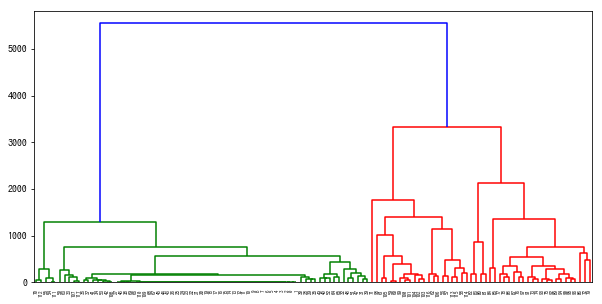

In [36]:
# 上のクラスタリング結果の樹状図を作成する。
plt.figure(figsize=(10, 5))
dend_dtw = hierarchy.dendrogram(connection_dtw)

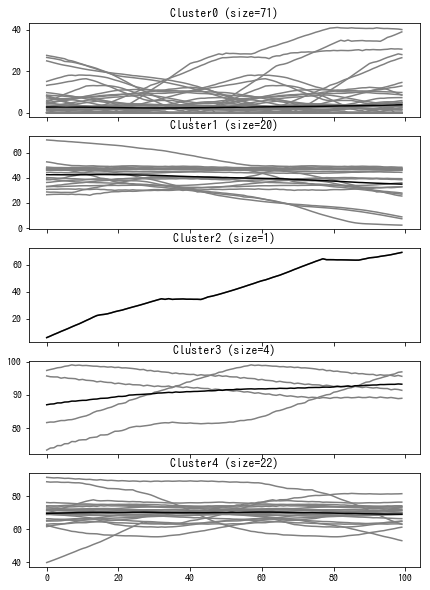

In [39]:
clusters = hierarchy.fcluster(connection_dtw, 5, criterion='maxclust') - 1
plot_serie_cluster(vehicle_speed.values,  clusters, width=100, step=50); plt.show()

両者の違いがはっきりするように並べて表示する。（左がユークリッド距離、右がDTW距離をそれぞれ用いた結果のプロット）

In [ ]:
Ima

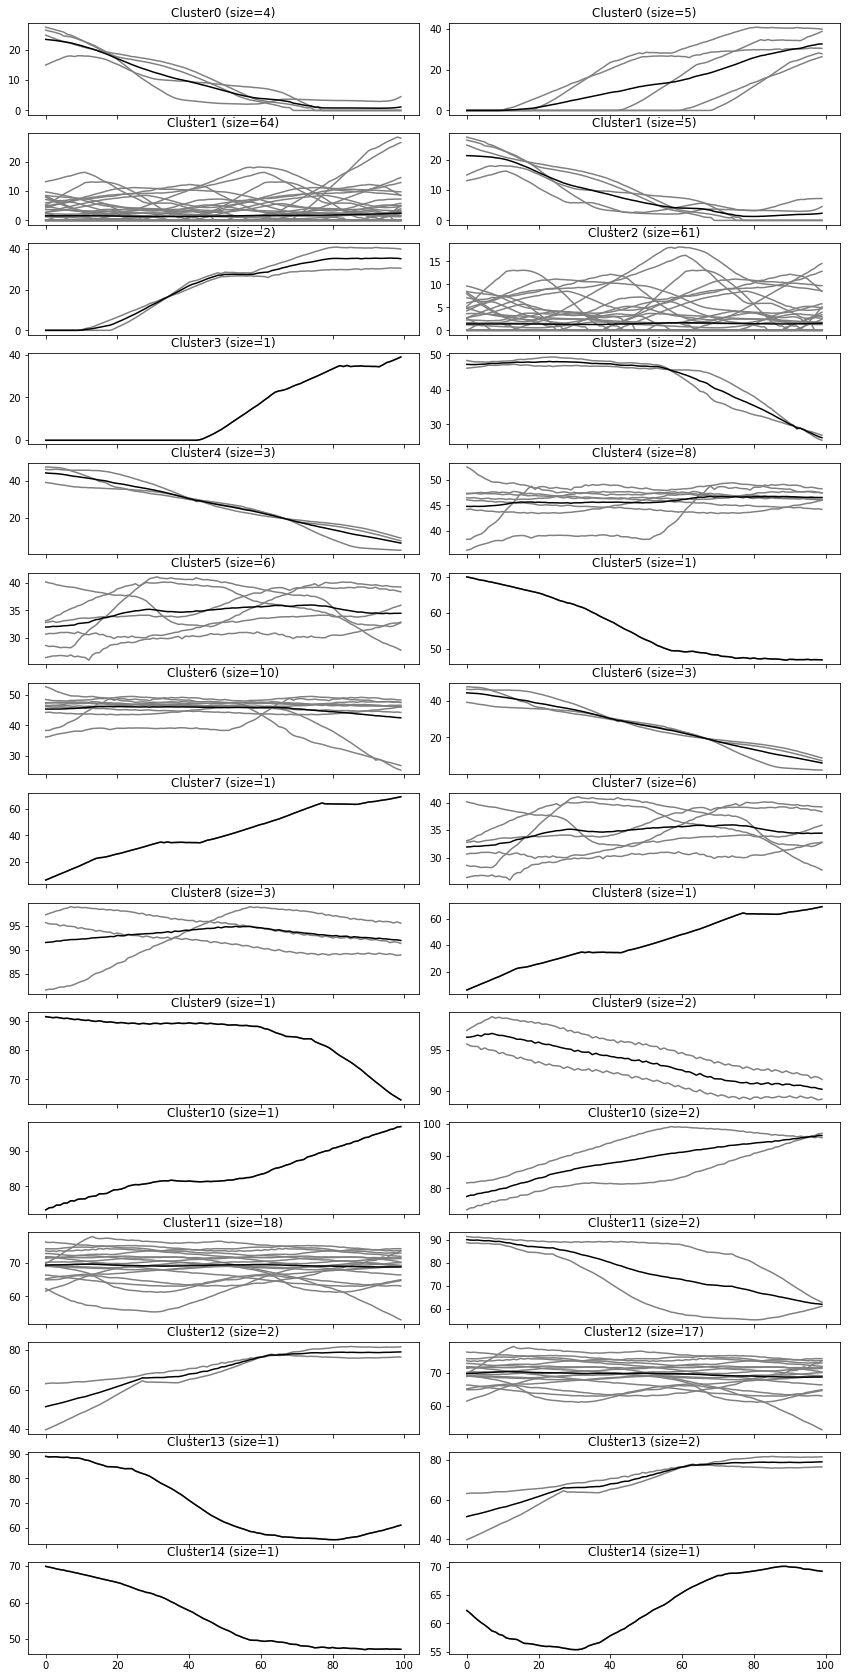

In [17]:
Image("15cluster_1.png")

ユークリッド距離を用いた場合は複数のクラスターに分かれていた速度0付近から加速する時系列パターンが、DTW距離を用いた場合はクラスター0にまとまっており、クラスタ2は加減速の入り交じっているパターンが集まっていることが見て取れる。

他のクラスタについても、DTWを用いた場合の方が直感的に言ってより近い時系列パターン同士がまとまっていると言えるのではないだろうか。


### 多次元の場合

DTW 距離は多次元の系列に対しても計算することが可能である。その実例として、10分程度の運転特徴群の、複数のセンサデータを使った時系列クラスタリングを行ってみよう。

In [18]:
# データの読み込み
df_multi_cars = pd.read_csv('../../../../work/CAN_SHUTTLE_PIVOT_3000000.csv')

In [19]:
# 計算が終わらないので一部の車体だけ使う。
used_cars = df_multi_cars[['carid', 'starttime']].drop_duplicates().sample(frac=0.005, random_state=41); used_cars

,carid,starttime
412492,52,201904151155
1223504,59,201904191355
2515246,89,201904251451
1965770,70,201904240833
2266917,71,201904250759
2350442,44,201904251044
237506,48,201904111510
51876,44,201904090909
1377391,65,201904221013
2989842,96,201904280735


In [20]:
# min max で正規化する
df_preprocessed = (
    df_multi_cars
    .merge(used_cars)
    .fillna(0)
    .sort_values(['carid', 'starttime', 'times'])
    .set_index(['carid', 'starttime', 'times'])
    .apply(lambda x: (x - x.min()) / (x.max() - x.min()) - 0.5)
    .reset_index()
    .fillna(0)
)
df_preprocessed

,carid,starttime,times,'A/C Switch On from Auto A/C','Engine Speed','Blower Fan Step from Auto AC','Yaw Rate 1(learmed data)','Driver Door Switch Status','Shift Down Switch Status','Lateral Sensor Value',...,'Mileage Information','Barometric Pressure','Park Brake Switch Active','Wheel Speed(Front Left)','Outside Air Temperature','Engine Intake Air Temperature','Tail Light SW','Turn Left SW','Brake Pedal Switch Active','Wheel Speed(Rear Left)'
0,42,201904100941,0.0,-0.5,-0.300805,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.213880,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.213563
1,42,201904100941,1.0,-0.5,-0.309459,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.210170,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.209167
2,42,201904100941,2.0,-0.5,-0.322567,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.212134,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.210046
3,42,201904100941,3.0,-0.5,-0.316912,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.218900,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.217081
4,42,201904100941,4.0,-0.5,-0.309116,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.227193,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.225654
5,42,201904100941,5.0,-0.5,-0.329849,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.228721,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.227852
6,42,201904100941,6.0,-0.5,-0.326765,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.228066,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.227632
7,42,201904100941,7.0,-0.5,-0.284184,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.218682,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.219279
8,42,201904100941,8.0,-0.5,-0.281871,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.212134,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.209607
9,42,201904100941,9.0,-0.5,-0.326851,-0.5,-0.019475,-0.5,0.0,-0.029412,...,0.493342,-0.500000,-0.5,-0.209952,-0.5000,-0.500000,0.0,-0.5,-0.5,-0.208288


In [21]:
%%time
# 運転特徴同士の距離行列を作成する。
grouped = df_preprocessed.groupby(['carid', 'starttime'])
cars_dist_mtx = np.zeros((grouped.ngroups, grouped.ngroups), np.float)

for i, (ind_i, grp_i) in enumerate(grouped):
    for j, (ind_j, grp_j) in enumerate(grouped):
        cars_dist_mtx[i, j] = fastdtw(grp_i.values, grp_j.values)[0]

cars_dist_mtx

/usr/local/anaconda3/envs/suzuki_teradata/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  import sys


CPU times: user 1min 5s, sys: 416 ms, total: 1min 6s
Wall time: 1min 6s


array([[0.00000000e+00, 6.41947253e+05, 1.21135018e+06, ...,
        1.07910191e+07, 9.04057880e+06, 1.07915827e+07],
       [6.41947253e+05, 0.00000000e+00, 5.69914004e+05, ...,
        1.01493117e+07, 8.39914498e+06, 1.01498353e+07],
       [1.21135018e+06, 5.69914004e+05, 0.00000000e+00, ...,
        9.57989480e+06, 7.82932320e+06, 9.58046179e+06],
       ...,
       [1.07910191e+07, 1.01493117e+07, 9.57989480e+06, ...,
        0.00000000e+00, 1.75459989e+06, 6.45695217e+02],
       [9.04057880e+06, 8.39914498e+06, 7.82932320e+06, ...,
        1.75459989e+06, 0.00000000e+00, 1.75492321e+06],
       [1.07915827e+07, 1.01498353e+07, 9.58046179e+06, ...,
        6.45695217e+02, 1.75492321e+06, 0.00000000e+00]])

In [22]:
# linkage 関数で計算するために距離行列を condensed 形式にする。
cond_cars_dist_mtx = squareform((cars_dist_mtx + cars_dist_mtx.T) / 2)
connection_cars = hierarchy.linkage(cond_cars_dist_mtx, method='average')

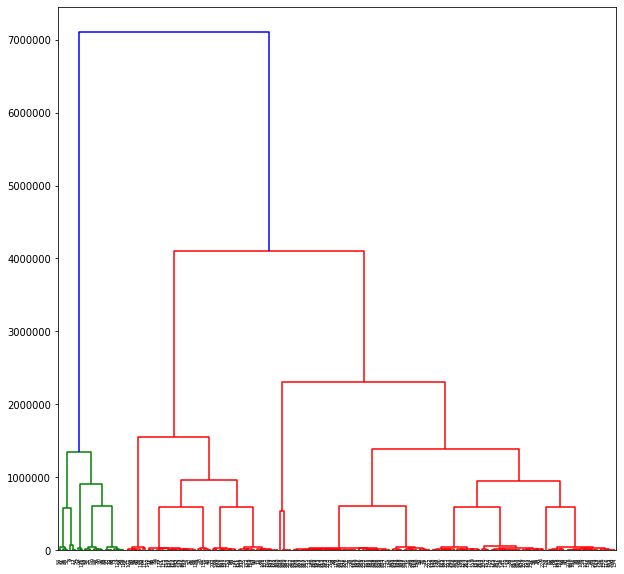

In [23]:
# 上のクラスタリング結果の樹状図を作成する。
plt.figure(figsize=(10, 10))
dend = hierarchy.dendrogram(connection_cars)

In [57]:
car_clusters_15 = hierarchy.fcluster(connection_cars, 15, criterion='maxclust') - 1

In [58]:
df_cluster = (
    grouped
    .apply(lambda x: 0).reset_index().drop(0, axis=1)
    .assign(cluster=car_clusters_15)
)
df_cluster

,carid,starttime,cluster
0,42,201904100941,2
1,42,201904111635,3
2,42,201904121127,1
3,42,201904161113,5
4,42,201904171558,5
5,42,201904231451,11
6,42,201904241721,12
7,43,201904090725,0
8,43,201904091914,0
9,43,201904100721,2


In [55]:
from sklearn.decomposition import PCA

pca = PCA(1)
pc = pca.fit_transform(df_preprocessed.drop(['carid', 'starttime', 'times'], axis=1))-=
df_pc = df_preprocessed[['carid', 'starttime', 'times']].assign(pc=pc).merge(df_cluster)

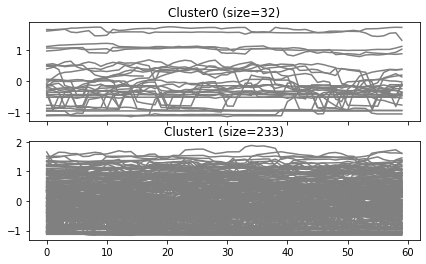

In [56]:
size = (7, 2)

clusters = df_pc[['carid', 'starttime', 'cluster']].drop_duplicates().cluster
unique_clusters = clusters.drop_duplicates()
n_clusters = len(unique_clusters)
fig, axs = plt.subplots(n_clusters, figsize=(size[0], size[1] * n_clusters))
n_data_points = Counter(clusters)


for i, df in df_pc.groupby(['cluster', 'carid', 'starttime']):
    axs[i[0]].plot(list(range(df.shape[0])), df.pc, color="gray")

for cl in unique_clusters:
    # サブプロットのタイトルを表示
    axs[cl].set_title(f"Cluster{cl} (size={n_data_points[cl]})")
    axs[cl].label_outer()

上記のように運転特徴のクラスタリングを行うことができる。

ここでは運転特徴同士の比較に直接DTWを用いたが、長い時間の運転特徴の時系列を直接比較した場合には運転自体の特徴というよりもその時走っていたコースなどが大きく影響すると考えらえる。

時系列のクラスタリングを運転の特徴と繋げる際には異なるアプローチも考えられる。

最初に行ったようなより短い時系列クラスタリングの結果を用いれば加減速などのパターンにラベリングを行うことができる。そういった加減速パターンの頻度などを比較することでも運転の特徴を把握することができるかもしれない。